In [1]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt

### my library

import plots
import utils
import images
import distances
import transforms
import alignments

In [2]:
# ### MNIST DATA
# mnist_image_file = 'Data/t10k-images-idx3-ubyte.gz'
# mnist_label_file = 'Data/t10k-labels-idx1-ubyte.gz'
# mnist_images = utils.load_mnist_images(mnist_image_file)
# mnist_labels = utils.load_mnist_labels(mnist_label_file)
# digit = 2
# loc = np.argwhere(digit == mnist_labels).flatten()
# digit_images = mnist_images[loc]

# L = 65
# img = mnist_images[1]
# x = np.array([img, img])
# x = utils.zero_pad_image_stack_to_size(x, L)[0]


# ### CAMERA MAN DATA
# from skimage import data
# L = 512
# x = data.camera() * utils.sphere_mask(utils.radial_distance_grid([L, L]), radius=128)


# ### DISK
# L = 128
# x = np.ones((L,L))
# x = x * utils.sphere_mask(utils.radial_distance_grid([L,L]), radius=128)


# ### SQUARE
# L = 128
# x = np.zeros((L,L))
# x[54:74, 54:74] = 1


# ### GAUSSIAN
L = 128  # Image size
sigma = 2  # Gaussian spread
x = utils.generate_centered_gaussian(L=L, d=2, sigma=sigma)

In [3]:
n_shifts = 20
shifts = np.arange(n_shifts+1)
imgs = np.zeros((n_shifts+1, L, L))

for idx, s in enumerate(shifts):
    imgs[idx] = utils.translate(x, 0, s)
    
imgs = images.Image(imgs, normalize=True, mask=True).preprocess_images()

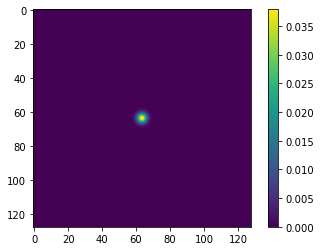

In [4]:
plt.imshow(imgs[0])
plt.colorbar()
plt.show()

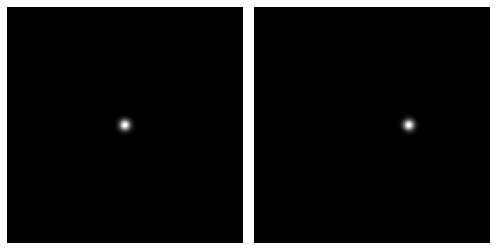

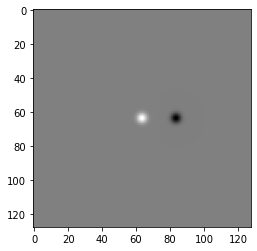

In [5]:
s_idx = -1
plots.two_imshow(imgs[0], imgs[s_idx], cmap='gray')
plt.imshow(imgs[0] - imgs[s_idx], cmap='gray')
plt.show()

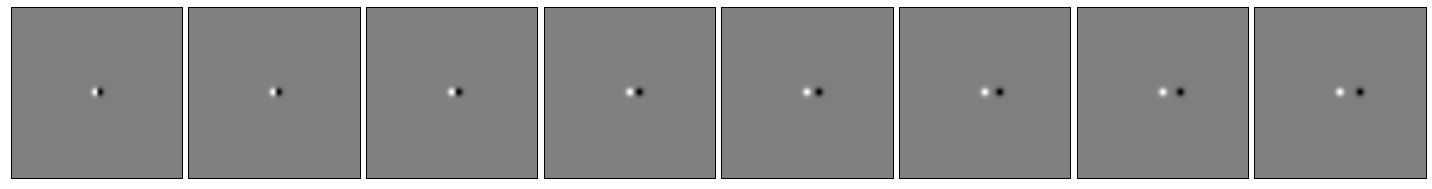

In [6]:
t = 8
plots.line_tile_plot(imgs[0] - imgs[1:n_shifts:n_shifts//t], t, size=20, spine_colors=['k' for _ in range(10)], cmap='gray')

In [7]:
N, ny, nx = imgs.shape
n_points = ny
angles = np.linspace(0, 360, ny, endpoint=False)
n_theta = len(angles)


### sliced Cramer distance (no ramp filter)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()
dists_sc_nrf = np.array([distances.sliced_distance(V[0], V[idx]) for idx in range(N)])


### sliced Wasserstein distance (no ramp filter)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
dists_sw_nrf = np.array([distances.sliced_distance(V[0], V[idx]) for idx in range(N)])
    

### sliced Wasserstein distance (signed)
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
dists_sw_sgn = np.array([distances.signed_sliced_distance(Vp[0], Vp[idx], Vn[0], Vn[idx]) for idx in range(N)])


## Euclidean
dists_l2 = np.array([distances.l2_distance(imgs[0], imgs[idx]) for idx in range(N)])

In [8]:
upper_bound_sw = np.sqrt(2) / 2 * (shifts / L)

upper_bound_sc = np.sqrt(2) * (shifts / L) 

upper_bound_l2 = np.ones(len(shifts)) * 2 * np.sum(imgs[0]**2)

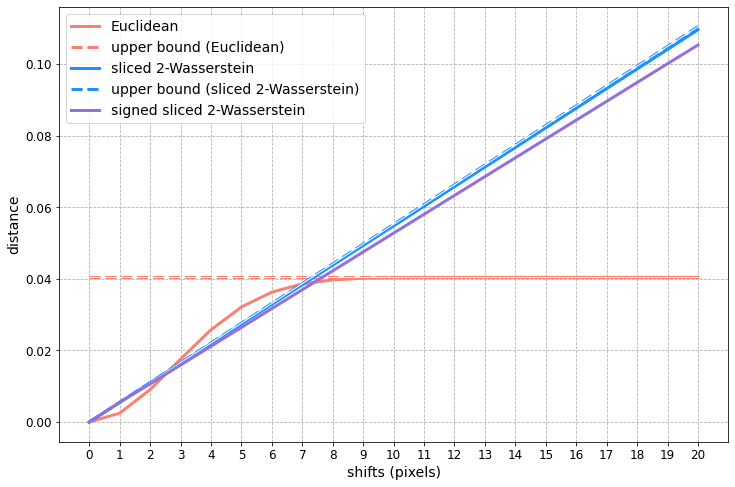

In [11]:
plt.figure(figsize=(12,8))

colors = {'sw_nrf': 'dodgerblue',
          'sw_sgn': 'mediumpurple',
          'sw_max': 'pink',
          'sc_nrf': 'green',
          'bf': 'salmon', 
          'w2': 'blue'}


plt.plot(shifts[:], dists_l2[:], color=colors['bf'], linestyle='-', linewidth=3, label='Euclidean')

plt.plot(shifts[:], upper_bound_l2[:], color=colors['bf'], linestyle='--', linewidth=3, label='upper bound (Euclidean)')
plt.plot(shifts[:], upper_bound_l2[:], color='white', linestyle='-', linewidth=1)

# plt.plot(shifts[:], dists_sc_nrf[:], color=colors['sc_nrf'], linestyle='-', linewidth=3, label='sliced 2-Cramer')

# plt.plot(shifts[:], upper_bound_sc[:], color=colors['sc_nrf'], linestyle='--', linewidth=3, label='upper bound (sliced 2-Cramer)')
# plt.plot(shifts[:], upper_bound_sc[:], color='white', linestyle='-', linewidth=1)

plt.plot(shifts[:], dists_sw_nrf[:], color=colors['sw_nrf'], linestyle='-', linewidth=3, label='sliced 2-Wasserstein')

plt.plot(shifts[:], upper_bound_sw[:], color=colors['sw_nrf'], linestyle='--', linewidth=3, label='upper bound (sliced 2-Wasserstein)')
plt.plot(shifts[:], upper_bound_sw[:], color='white', linestyle='-', linewidth=1)

plt.plot(shifts[:], dists_sw_sgn[:], color=colors['sw_sgn'], linestyle='-', linewidth=3, label='signed sliced 2-Wasserstein')



plt.xticks(shifts)
plt.grid(which='major', linestyle='--')
plt.ylabel('distance')
plt.xlabel('shifts (pixels)')
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)
plt.legend()
plt.show()